# Heart Axis Prediction

This example shows how to train an adiabatic linear regression on a medical records (heart axis) dataset.

To train Addiabatic Linear Regression, the database of patients electrocardiogram (ECG) records in form of the .csv files was used. The description of the dataset could be found [here](https://figshare.com/collections/ChapmanECG/4560497/2). From the ECGs data the information about the I and III leads was extracted using Python Scipy package for the signal processing. 

For the Addiabatic Linear Regression training, we used to filter the database to collect the data about healthy heart functioning as desctibed in [Combined Effects of Age and Comorbidities on Electrocardiographic Parameters in a Large Non-Selected Population](https://doi.org/10.3390/jcm11133737). The data is devided into age groups, and the data in each age group is averaged. The records of patients who 15 year old or younger are excluded since their data are highly unlinear. 

In [1]:
import numpy as np
import sklearn.datasets as dt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import json
import pandas as pd
import sys

sys.path.append("../")

In [2]:
from qml_adiabatic import QALinearRegression

## Data Preparation

In [3]:
def get_qrs_axis(df_heart):
    """
    Calcualtes age and QRS Axis for different age groups. 
    The result is the mean value for each age group.
    
    Args: 
        df_heart: a pandas dataframe with the records.
    
    Returns:
        age: a sorted np.array with the patient ages
        qrsaxis: a sorted np.array with the patient measurements on QRS axis.
    """
    
    df_normal = pd.DataFrame(columns=[ 'Age', 'QTc', 'QRSDuration', 'QRSAxis'])
    for index in df_heart.index:
        if df_heart["QRSAxis"][index] in range(-30, 90):
            df_normal = df_normal.append(df_heart.iloc[[index]], ignore_index=True)
    
    df_normal.sort_values(by=["Age"], ascending=True, inplace=True)
    df_normal.drop(df_normal[df_normal["Age"] <=14 ].index, inplace=True)

    age_bygroup = []
    qrsaxis_byage = []

    for age_group in range(15, 91, 5):
        age_bygroup.append(age_group+2)
        mean_qrs = df_normal.loc[(df_normal["Age"] >=age_group) & (df_normal["Age"] <= age_group+4), "QRSAxis"].mean()
        qrsaxis_byage.append(mean_qrs)

    return np.asarray(age_bygroup), np.asarray(qrsaxis_byage)

In [4]:
def get_data_for_training():
    """
        Prepares the data for classical ML training or for training as Addiabatic Linear Regression.
        The data is grouped and analized by age groups as described in the article
        https://pubmed.ncbi.nlm.nih.gov/35807018/ .
        Normal QRS_axis is in range of -30 to +90 degrees.
        
        Args: 
            None.
        Returns:
            age: a sorted np.array with the patient ages
            qrs_axis: a sorted np.array with the patient measurements on QRS axis.
    """

    with open('../dataset/heart_data.json') as file:
        data = json.load(file)

    df_end = pd.DataFrame.from_dict(data["data"])
    
    # convert ECG axis from -30 deg to 180 deg.
    for index in df_end.index:
        if df_end["QRSAxis"][index] in range(0, 180):
            df_end["QRSAxis"][index] = -df_end["QRSAxis"][index]
        elif df_end["QRSAxis"][index] in range(180, 360):
            df_end["QRSAxis"][index] = abs(360 - df_end["QRSAxis"][index])

    age, qrs_axis = get_qrs_axis(df_end)
    
    return age, qrs_axis
    

## Training

In [5]:
age, qrs = get_data_for_training() #get data

# split fro train-test
age_train, age_test, qrs_train, qrs_test = train_test_split(age, qrs, test_size=0.25, random_state=42) 

print("Initialize and train Quantum Linear Regression . . .")
precision_vector = np.array([0, 0.125, 0.25, 0.5, 0.75])
# use the RobustScaler to decrease the influence of the outliers
qrs_lin_regression = QALinearRegression(precision_vector=precision_vector, normalize=True, scaler="RobustScaler")
qrs_lin_regression.train(age_train.reshape(-1, 1), qrs_train)
qrs_predicted = qrs_lin_regression.predict(age_train.reshape(-1,1))

Initialize and train Quantum Linear Regression . . .


In [6]:
# compare with a classical linear regression in Scikit-learn
print("Initialize and train Classical Linear Regression . . .")
model= LinearRegression()
trained_model = model.fit(age_train.reshape(-1, 1), qrs_train)
y_predict = trained_model.predict(age_train.reshape(-1,1))

Initialize and train Classical Linear Regression . . .


R^2 on training dataset for Scikit-Learn: 0.94383692314776
R^2 on training dataset for Adiabatic Linear Regression: 0.8898309926203356


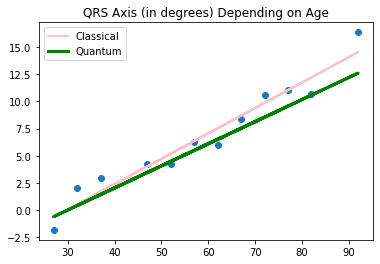

In [7]:
print("R^2 on training dataset for Scikit-Learn:", r2_score(qrs_train, y_predict))
print("R^2 on training dataset for Adiabatic Linear Regression:", qrs_lin_regression.r_score(qrs_train, qrs_predicted))
# plot
plt.scatter(age_train, qrs_train)
plt.plot(age_train, y_predict, color='pink', linewidth=2, label='Classical')
plt.plot(age_train, qrs_predicted, color='green', linewidth=3, label='Quantum')
plt.legend(loc='upper left')
plt.title("QRS Axis (in degrees) Depending on Age")
plt.show()

## Prediction and Evaluation

In [8]:
print("Evaluate Quantum Linear Regression . . .")
qrs_predicted_eval = qrs_lin_regression.predict(age_test.reshape(-1,1))
qrs_classical = model.predict(age_test.reshape(-1,1))

print("Age {}".format(age_test))
print("Predicted QRS Axis {}".format(qrs_predicted_eval))

# print metrics
print('MAE for the Adiabatic Linear Regression = ', qrs_lin_regression.mae(qrs_test, qrs_predicted_eval))
print('MSE for the Adiabatic Linear Regression = ', qrs_lin_regression.mse(qrs_test, qrs_predicted_eval))
print('Root MSE for the Adiabatic Linear Regression = ', qrs_lin_regression.root_mse(qrs_test, qrs_predicted_eval))
print('R^2 on test dataset for the Adiabatic Linear Regression = ', qrs_lin_regression.r_score(qrs_test, qrs_predicted_eval))
print('R^2 on test dataset for the Sklearn Linear Regression = ', qrs_lin_regression.r_score(qrs_test, qrs_classical))


Evaluate Quantum Linear Regression . . .
Age [17 22 42 87]
Predicted QRS Axis [[ 3.30721557]
 [ 4.20481038]
 [ 7.79518962]
 [15.87354292]]
MAE for the Adiabatic Linear Regression =  7.581347240389968
MSE for the Adiabatic Linear Regression =  229.90730391747437
Root MSE for the Adiabatic Linear Regression =  15.162694480779937
R^2 on test dataset for the Adiabatic Linear Regression =  0.4043312141285681
R^2 on test dataset for the Sklearn Linear Regression =  0.14291769531049192


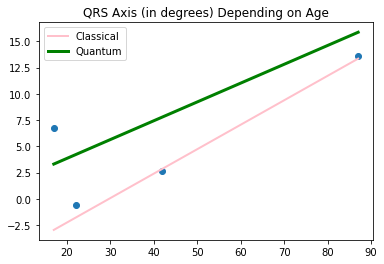

In [9]:
plt.scatter(age_test, qrs_test)
plt.plot(age_test, qrs_classical, color='pink', linewidth=2, label='Classical')
plt.plot(age_test, qrs_predicted_eval, color='green', linewidth=3, label='Quantum')
plt.legend(loc='upper left')
plt.title("QRS Axis (in degrees) Depending on Age")
plt.show()